In [51]:
# importando as bibliotecas que estaremos usando no trabalho
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

In [52]:
# importando o dataset
covid = pd.read_csv(r'caso.csv', encoding = "utf-8")
covid.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
count,441580.000000,441580.000000,441580.000000,4.395410e+05,4.395410e+05,429678.000000,441580.000000
mean,434.457441,18.833450,45.693168,1.224538e+05,3.157370e+06,360.807330,0.046762
std,5535.380670,289.431766,29.934186,1.174799e+06,1.011723e+06,660.918303,0.128928
min,0.000000,0.000000,1.000000,7.810000e+02,1.100000e+01,0.002180,0.000000
25%,3.000000,0.000000,21.000000,7.173000e+03,2.500809e+06,28.946910,0.000000
50%,15.000000,0.000000,42.000000,1.584600e+04,3.136702e+06,118.868640,0.000000
75%,79.000000,2.000000,67.000000,3.511100e+04,4.106902e+06,408.120412,0.040000
max,529006.000000,22710.000000,155.000000,4.591905e+07,5.300108e+06,15717.926930,1.000000


In [53]:
# vamos começar pelo pre processamento de dados

In [54]:
# olhando para o tamanho do dataset vemos que temos 441580 linhas e 12 colunas 
# mas estaremos usando apenas uma fração desses dados, Recife e São Paulo 
# também adicionaremos outras colunas que acharmos necessário
covid.shape

(441580, 12)

In [55]:
# como ha dados com tipos object, o que nao pode ser bom pra categorizar, vamos mudar pra tipo categorico
covid.dtypes

date                               object
state                              object
city                               object
place_type                         object
confirmed                           int64
deaths                              int64
order_for_place                     int64
is_last                              bool
estimated_population_2019         float64
city_ibge_code                    float64
confirmed_per_100k_inhabitants    float64
death_rate                        float64
dtype: object

In [56]:
# ajustando tipos dos dados
covid['date'] = covid['date'].astype('category') 
covid['state'] = covid['state'].astype('category') 
covid['city'] = covid['city'].astype('category') 
covid['place_type'] = covid['place_type'].astype('category') 
covid.dtypes

date                              category
state                             category
city                              category
place_type                        category
confirmed                            int64
deaths                               int64
order_for_place                      int64
is_last                               bool
estimated_population_2019          float64
city_ibge_code                     float64
confirmed_per_100k_inhabitants     float64
death_rate                         float64
dtype: object

In [57]:
covid['state'].cat.categories

Index(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS',
       'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC',
       'SE', 'SP', 'TO'],
      dtype='object')

In [58]:
# o nosso próximo passo eh ver a quantidade de elementos nulos em cada coluna e podemos observar que ha 4 colunas bastante dados nulos 
print(covid.isnull().sum())

date                                  0
state                                 0
city                               3706
place_type                            0
confirmed                             0
deaths                                0
order_for_place                       0
is_last                               0
estimated_population_2019          2039
city_ibge_code                     2039
confirmed_per_100k_inhabitants    11902
death_rate                            0
dtype: int64


In [59]:
covidRecife = covid[covid.city=='Recife']
covidRecife.isnull().sum()

date                              0
state                             0
city                              0
place_type                        0
confirmed                         0
deaths                            0
order_for_place                   0
is_last                           0
estimated_population_2019         0
city_ibge_code                    0
confirmed_per_100k_inhabitants    0
death_rate                        0
dtype: int64

In [60]:
covidSP = covid[covid.city=='São Paulo']
covidSP.isnull().sum()

date                              0
state                             0
city                              0
place_type                        0
confirmed                         0
deaths                            0
order_for_place                   0
is_last                           0
estimated_population_2019         0
city_ibge_code                    0
confirmed_per_100k_inhabitants    0
death_rate                        0
dtype: int64

In [61]:
# como vimos acima que os dados que iremos trabalhar nao tem nenhum dado ausente, decidimos por limpar o dataset original com instâncias com ao menos 1 coluna com dado ausente
covid = covid.dropna()
covid.shape

(425978, 12)

In [62]:
# Normalização

# min-max do scikit
scaler = MinMaxScaler()
covidRecife['confirmed_norm'] = scaler.fit_transform(covidRecife[['confirmed']])
covidRecife['confirmed_norm'].describe()

count    136.000000
mean       0.436117
std        0.353877
min        0.000000
25%        0.046556
50%        0.484167
75%        0.768430
max        1.000000
Name: confirmed_norm, dtype: float64

In [63]:
# Discretização

# discretizando com 10 bins com mesmo intervalo
covidRecife['deaths_dist'] = pd.cut(covidRecife['deaths'],4)

In [64]:
covidRecife['deaths_dist'].value_counts()

(-2.109, 527.25]     60
(1581.75, 2109.0]    43
(1054.5, 1581.75]    18
(527.25, 1054.5]     15
Name: deaths_dist, dtype: int64

In [65]:
covidRecife['deaths'].describe()

count     136.000000
mean      912.095588
std       794.606363
min         0.000000
25%        91.750000
50%       819.000000
75%      1752.500000
max      2109.000000
Name: deaths, dtype: float64

In [66]:
# uma estatística importante no nosso trabalho eh o número de mortes por dia, mas isso nao tem no dataset, por isso criamos esta função que adiciona esta coluna usando o metodo diff

# pegando os dados de Recife, resetando o index e adicionando as colunas
covidRecife = covidRecife.sort_values(by=['date'], ascending=True)
covidRecife.reset_index(inplace=True, drop=True)

# utilizando o diff() do pandas para calcular a diferença entre linhas consecutivas
covidRecife['deaths_per_day'] = covidRecife.deaths.diff().abs()

# aqui eu imputo o dado pois o resultado da função diff() executada acima faz com que tenhamos um NaN na primeira linha da nova coluna e para nao perder os dados do primeiro dia não utilizamos o dropna() aqui e nem nas próximas colunas criadas da mesma forma. 
covidRecife['deaths_per_day'][0] = 0

covidRecife.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,confirmed_norm,deaths_dist,deaths_per_day
0,2020-03-12,PE,Recife,city,2,0,1,False,1645727.0,2611606.0,0.12153,0.0,0.000000,"(-2.109, 527.25]",0.0
1,2020-03-13,PE,Recife,city,2,0,2,False,1645727.0,2611606.0,0.12153,0.0,0.000000,"(-2.109, 527.25]",0.0
2,2020-03-14,PE,Recife,city,6,0,3,False,1645727.0,2611606.0,0.36458,0.0,0.000152,"(-2.109, 527.25]",0.0
3,2020-03-15,PE,Recife,city,7,0,4,False,1645727.0,2611606.0,0.42534,0.0,0.000190,"(-2.109, 527.25]",0.0
4,2020-03-17,PE,Recife,city,13,0,5,False,1645727.0,2611606.0,0.78992,0.0,0.000419,"(-2.109, 527.25]",0.0


In [67]:
# pegando  dados de São Paulo, resetando o index e adicionando as colunas
covidSP = covid[covid.city == 'São Paulo'].sort_values(by=['date'], ascending=True)
covidSP.reset_index(inplace=True, drop=True)
covidSP['deaths_per_day'] = covidSP.deaths.diff().abs()

# aqui eu imputo o dado para nao perder os dados do primeiro dia
covidSP['deaths_per_day'][0] = 0
covidSP.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day
0,2020-02-25,SP,São Paulo,city,1,0,1,False,12252023.0,3550308.0,0.00816,0.0,0.0
1,2020-02-26,SP,São Paulo,city,1,0,2,False,12252023.0,3550308.0,0.00816,0.0,0.0
2,2020-02-27,SP,São Paulo,city,1,0,3,False,12252023.0,3550308.0,0.00816,0.0,0.0
3,2020-02-28,SP,São Paulo,city,2,0,4,False,12252023.0,3550308.0,0.01632,0.0,0.0
4,2020-02-29,SP,São Paulo,city,2,0,5,False,12252023.0,3550308.0,0.01632,0.0,0.0


In [68]:
# não eh uma boa estrategia comparar o número de mortes bruto em duas cidades com quantidades de habitantes discrepantes
# por isso vamos usar a função apply do pandas para ter número de mortes a cada 100 mil de habitantes

print("População de Recife: ", covidRecife.estimated_population_2019[0])
print("População de São Paulo: ", covidSP.estimated_population_2019[0])

População de Recife:  1645727.0
População de São Paulo:  12252023.0


In [69]:

# adicionando coluna do total de mortes por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['deaths_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['deaths']/(x['estimated_population_2019'] / 100000), axis=1).abs()

covidSP['deaths_per_100k_inhabitants'] = covidSP.apply(lambda x: x['deaths']/(x['estimated_population_2019'] / 100000), axis=1).abs()

# tratando indice 0 com NaN
covidRecife['deaths_per_100k_inhabitants'][0] = 0
covidSP['deaths_per_100k_inhabitants'][0] = 0


In [70]:
# adicionando coluna de mortes por dia por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['deaths_per_day_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['deaths_per_day']/(x['estimated_population_2019'] / 100000), axis=1).abs()

covidSP['deaths_per_day_per_100k_inhabitants'] = covidSP.apply(lambda x: x['deaths_per_day']/(x['estimated_population_2019'] / 100000), axis=1).abs()

# tratando indice 0 com NaN
covidRecife['deaths_per_day_per_100k_inhabitants'][0] = 0
covidSP['deaths_per_day_per_100k_inhabitants'][0] = 0


In [71]:
# adicionando coluna de casos confirmados por dia nos dataframes de Recife e São Paulo
covidRecife['confirmed_per_day'] = covidRecife.confirmed.diff().abs()
covidSP['confirmed_per_day'] = covidSP.confirmed.diff().abs()

# adicionando coluna de casos confirmados por dia por dia por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['confirmed_per_day_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['confirmed_per_day']/(x['estimated_population_2019'] / 100000), axis=1).abs()
covidSP['confirmed_per_day_per_100k_inhabitants'] = covidSP.apply(lambda x: x['confirmed_per_day']/(x['estimated_population_2019'] / 100000), axis=1).abs()

# tratando indice 0 com NaN
covidRecife['confirmed_per_day'][0] = 0
covidSP['confirmed_per_day'][0] = 0

covidRecife['confirmed_per_day_per_100k_inhabitants'][0] = 0
covidSP['confirmed_per_day_per_100k_inhabitants'][0] = 0

covidSP.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants
count,148.000000,148.000000,148.000000,148.0,148.0,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,60870.594595,3613.662162,74.500000,12252023.0,3550308.0,496.820766,0.057508,63.986486,29.494412,0.522252,1308.668919,10.681248
std,61514.761222,3238.064725,42.868014,0.0,0.0,502.078402,0.025278,52.180611,26.428817,0.425894,1275.497307,10.410504
min,1.000000,0.000000,1.000000,12252023.0,3550308.0,0.008160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6093.750000,418.750000,37.750000,12252023.0,3550308.0,49.736688,0.053100,17.000000,3.417803,0.138753,284.000000,2.317985
50%,36059.500000,2845.500000,74.500000,12252023.0,3550308.0,294.314660,0.060900,47.500000,23.224736,0.387691,964.000000,7.868088
75%,110975.750000,6606.000000,111.250000,12252023.0,3550308.0,905.774910,0.076325,113.250000,53.917627,0.924337,2106.250000,17.191039
max,193684.000000,9470.000000,148.000000,12252023.0,3550308.0,1580.832810,0.086500,179.000000,77.293358,1.460983,6877.000000,56.129506


In [72]:
covidRecife.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,confirmed_norm,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants
count,136.000000,136.000000,136.000000,136.0,136.0,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,11460.963235,912.095588,68.500000,1645727.0,2611606.0,696.407317,0.070254,0.436117,15.536765,55.422047,0.944067,199.301471,12.110239
std,9298.130331,794.606363,39.403892,0.0,0.0,564.986193,0.022550,0.353877,15.181816,48.283000,0.922499,192.567192,11.701041
min,2.000000,0.000000,1.000000,1645727.0,2611606.0,0.121530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1225.250000,91.750000,34.750000,1645727.0,2611606.0,74.450378,0.064600,0.046556,3.000000,5.575044,0.182290,73.000000,4.435730
50%,12723.500000,819.000000,68.500000,1645727.0,2611606.0,773.123365,0.074650,0.484167,10.000000,49.765241,0.607634,170.500000,10.360163
75%,20192.500000,1752.500000,102.250000,1645727.0,2611606.0,1226.965345,0.084400,0.768430,24.250000,106.487893,1.473513,256.250000,15.570626
max,26277.000000,2109.000000,136.000000,1645727.0,2611606.0,1596.680370,0.109600,1.000000,65.000000,128.150052,3.949622,1061.000000,64.469988


In [73]:
# o nosso objetivo neste trabalho eh analisar especificamente as cidade de Recife e São Paulo, e como vimos, os dados nao apresentam falha com relação a elementos nulos, por isso a imputação de dados não vai ser necessaria. 

# sobre detecção de outliers ...

Text(0.5, 0, 'Cidades')

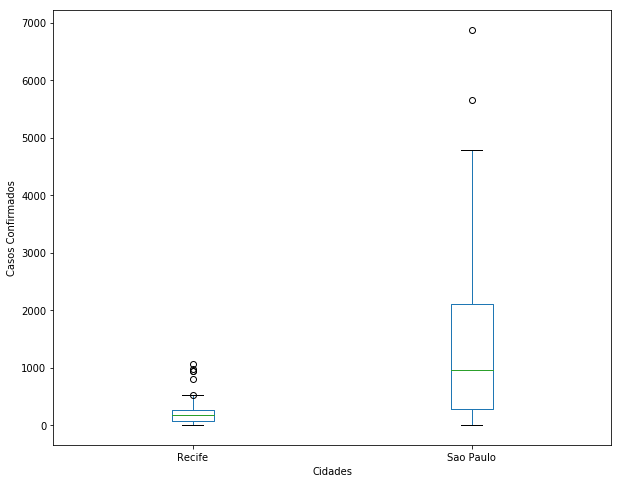

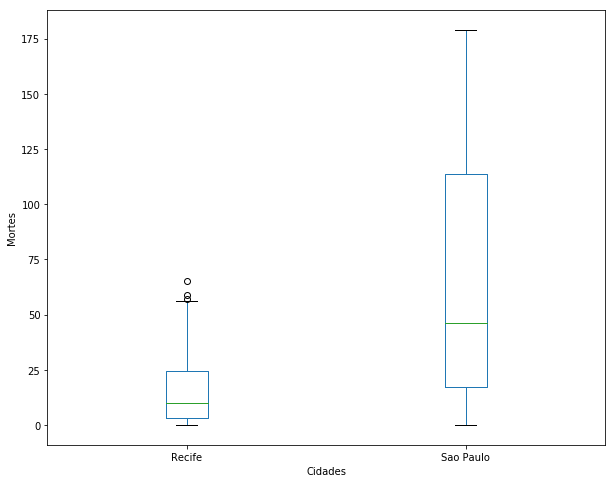

In [74]:
crec_confirmed_per_day = covidRecife.confirmed_per_day[0:-1:1]
csp_confirmed_per_day = covidSP.confirmed_per_day[0:-1:1]
plot_confirmed_per_day_box = pd.concat([crec_confirmed_per_day, csp_confirmed_per_day], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed_per_day_box.plot(kind='box', figsize=[10, 8])
plt.ylabel('Casos Confirmados')
plt.xlabel('Cidades')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes total em Recife (azul) e São Paulo (laranja)
crec_deaths_per_day = covidRecife.deaths_per_day[0:-1:1]
csp_deaths_per_day = covidSP.deaths_per_day[0:-1:1]
plot_deaths_per_day_box = pd.concat([crec_deaths_per_day, csp_deaths_per_day], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths_per_day_box.plot(kind='box', figsize=[10, 8])
plt.ylabel('Mortes')
plt.xlabel('Cidades')


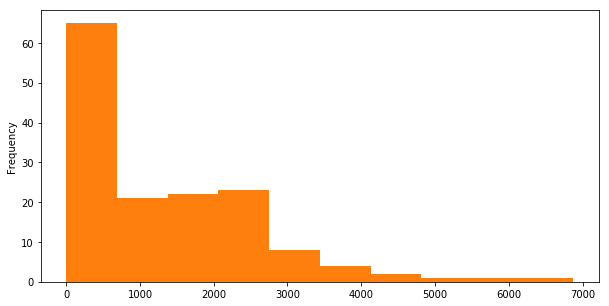

In [75]:
covidRecife['confirmed_per_day'].plot(kind="hist", figsize=(10,5))
covidSP['confirmed_per_day'].plot(kind="hist", figsize=(10,5))


In [76]:
covidSP.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants
0,2020-02-25,SP,São Paulo,city,1,0,1,False,12252023.0,3550308.0,0.00816,0.0,0.0,0.0,0.0,0.0,0.000000
1,2020-02-26,SP,São Paulo,city,1,0,2,False,12252023.0,3550308.0,0.00816,0.0,0.0,0.0,0.0,0.0,0.000000
2,2020-02-27,SP,São Paulo,city,1,0,3,False,12252023.0,3550308.0,0.00816,0.0,0.0,0.0,0.0,0.0,0.000000
3,2020-02-28,SP,São Paulo,city,2,0,4,False,12252023.0,3550308.0,0.01632,0.0,0.0,0.0,0.0,1.0,0.008162
4,2020-02-29,SP,São Paulo,city,2,0,5,False,12252023.0,3550308.0,0.01632,0.0,0.0,0.0,0.0,0.0,0.000000


In [77]:
# Detecção de Outliers

covidRecife1 = covidRecife.drop(columns=['date', 'state', 'city', 'place_type', 'is_last'], axis=1)
del covidRecife1['deaths_dist']

In [78]:
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(covidRecife1)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F1ECCC35468, verbose=0,
                warm_start=False)

In [79]:
scores = clf.predict(covidRecife1)

In [80]:
scores

array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
        1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [81]:
covidRecife1['outlier'] = scores

In [82]:
covidRecife1 = covidRecife1[covidRecife1['outlier'] != -1]
len(covidRecife1)

90

In [83]:
covidRecife1.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,confirmed_norm,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants,outlier
count,90.000000,90.000000,90.000000,90.0,90.0,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.0
mean,10448.211111,847.800000,63.488889,1645727.0,2611606.0,634.869034,0.070172,0.397572,11.377778,51.515227,0.691353,145.466667,8.839052,1.0
std,9529.589749,816.550971,40.491432,0.0,0.0,579.050459,0.024518,0.362687,10.410213,49.616429,0.632560,108.462306,6.590541,0.0
min,6.000000,0.000000,3.000000,1645727.0,2611606.0,0.364580,0.000000,0.000152,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,275.500000,22.500000,25.250000,1645727.0,2611606.0,16.740323,0.066175,0.010409,2.250000,1.367177,0.136718,44.500000,2.703972,1.0
50%,9062.000000,567.000000,62.000000,1645727.0,2611606.0,550.638105,0.075900,0.344814,8.500000,34.452859,0.516489,144.500000,8.780314,1.0
75%,20117.500000,1737.000000,101.750000,1645727.0,2611606.0,1222.408087,0.085425,0.765576,19.750000,105.546060,1.200078,234.250000,14.233831,1.0
max,24308.000000,2036.000000,127.000000,1645727.0,2611606.0,1477.037200,0.109600,0.925062,37.000000,123.714322,2.248247,401.000000,24.366131,1.0


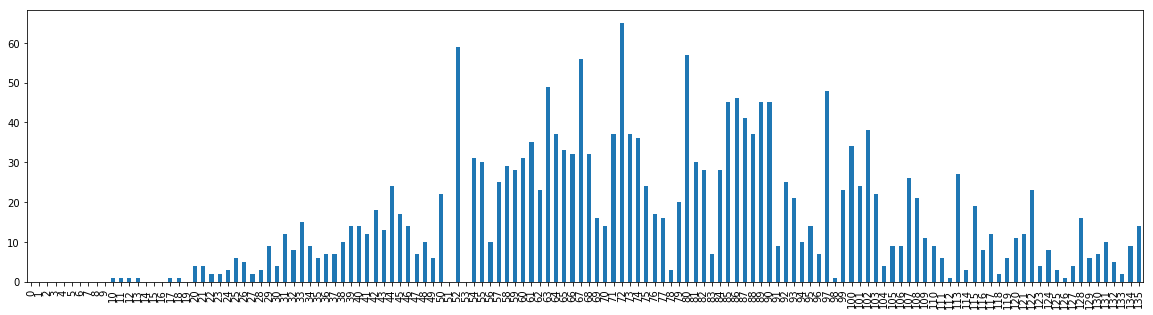

In [84]:
covidRecife['deaths_per_day'].plot(kind="bar", figsize=(20,5))

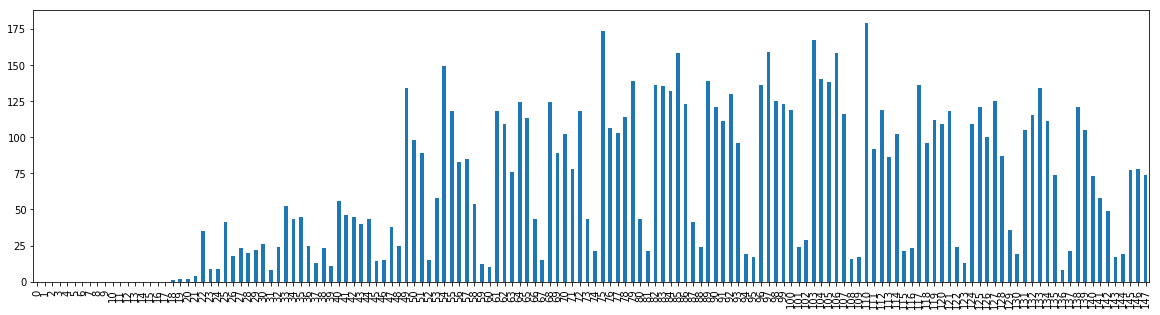

In [85]:
covidSP['deaths_per_day'].plot(kind="bar", figsize=(20,5))

Text(0.5, 0, 'dias')

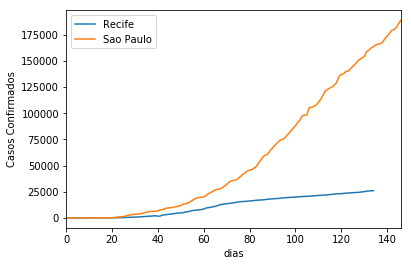

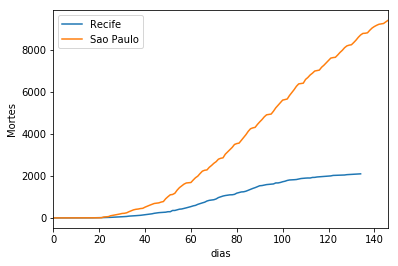

In [86]:
# comparação entre o número de casos confirmados totais em Recife (azul) e São Paulo (laranja)
crec_confirmed = covidRecife.confirmed[0:-1:1]
csp_confirmed = covidSP.confirmed[0:-1:1]
plot_confirmed = pd.concat([crec_confirmed, csp_confirmed], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes total em Recife (azul) e São Paulo (laranja)
crec_deaths = covidRecife.deaths[0:-1:1]
csp_deaths = covidSP.deaths[0:-1:1]
plot_deaths = pd.concat([crec_deaths, csp_deaths], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes')
plt.xlabel('dias')

# no grafico abaixo a cidade de São Paulo parece ter sido muito mais afetada do que Recife, pois temos uma curva de mortes muito maior

Text(0.5, 0, 'dias')

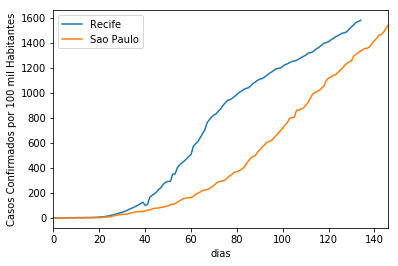

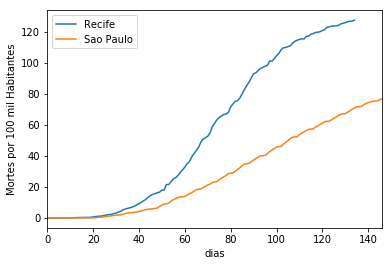

In [87]:
# Veremos agora o comparativo entre casos confirmados por 100 mil habitantes e mortes por 100 mil habitantes entre Recife e São Paulo

# comparação entre o número de casos confirmados por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_confirmed_per_100k_inhabitants = covidRecife.confirmed_per_100k_inhabitants[0:-1:1]
csp_confirmed_per_100k_inhabitants = covidSP.confirmed_per_100k_inhabitants[0:-1:1]
plot_confirmed_per_100k_inhabitants = pd.concat([crec_confirmed_per_100k_inhabitants, csp_confirmed_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados por 100 mil Habitantes')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_deaths_per_100k_inhabitants = covidRecife.deaths_per_100k_inhabitants[0:-1:1]
csp_deaths_per_100k_inhabitants = covidSP.deaths_per_100k_inhabitants[0:-1:1]
plot_deaths_per_100k_inhabitants = pd.concat([crec_deaths_per_100k_inhabitants, csp_deaths_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes por 100 mil Habitantes')
plt.xlabel('dias')

# no gráfico abaixo a cidade de Recife parece ter sido muito mais afetada do que São Paulo, pois temos uma curva maior em relação a casos confirmados/mortes por 100 mil habitantes

Text(0.5, 0, 'dias')

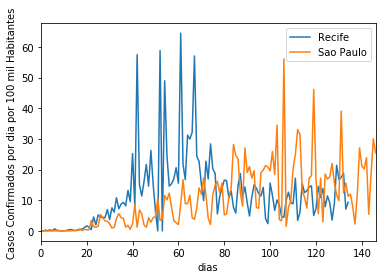

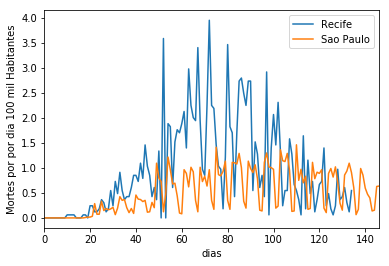

In [88]:

# comparação entre o número de casos confirmados por dia por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_confirmed_per_day_per_100k_inhabitants = covidRecife.confirmed_per_day_per_100k_inhabitants[0:-1:1]
csp_confirmed_per_day_per_100k_inhabitants = covidSP.confirmed_per_day_per_100k_inhabitants[0:-1:1]
plot_confirmed_per_day_per_100k_inhabitants = pd.concat([crec_confirmed_per_day_per_100k_inhabitants, csp_confirmed_per_day_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed_per_day_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados por dia por 100 mil Habitantes')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes por dia por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_deaths_per_day_per_100k_inhabitants = covidRecife.deaths_per_day_per_100k_inhabitants[0:-1:1]
csp_deaths_per_day_per_100k_inhabitants = covidSP.deaths_per_day_per_100k_inhabitants[0:-1:1]
plot_deaths_per_day_per_100k_inhabitants = pd.concat([crec_deaths_per_day_per_100k_inhabitants, csp_deaths_per_day_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths_per_day_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes por por dia 100 mil Habitantes')
plt.xlabel('dias')

# no gráfico abaixo a cidade de Recife parece ter sido muito mais afetada do que São Paulo, pois temos uma curva maior em relação a casos confirmados/mortes por 100 mil habitantes

In [89]:
# Aqui fazemos a correlação entre as colunas de covidRecife
covidRecife.corr(method='spearman')

,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,confirmed_norm,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants
confirmed,1.000000,0.999730,0.999943,0.147980,NaN,NaN,1.000000,0.608326,1.000000,0.374340,0.999730,0.374340,0.416888,0.416888
deaths,0.999730,1.000000,0.999778,0.148011,NaN,NaN,0.999730,0.611277,0.999730,0.375381,1.000000,0.375381,0.418098,0.418098
order_for_place,0.999943,0.999778,1.000000,0.147979,NaN,NaN,0.999943,0.610525,0.999943,0.374024,0.999778,0.374024,0.417079,0.417079
is_last,0.147980,0.148011,0.147979,1.000000,NaN,NaN,0.147980,0.025217,0.147980,0.026342,0.148011,0.026342,0.080022,0.080022
estimated_population_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_ibge_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confirmed_per_100k_inhabitants,1.000000,0.999730,0.999943,0.147980,NaN,NaN,1.000000,0.608326,1.000000,0.374340,0.999730,0.374340,0.416888,0.416888
death_rate,0.608326,0.611277,0.610525,0.025217,NaN,NaN,0.608326,1.000000,0.608326,0.064696,0.611277,0.064696,-0.039562,-0.039562
confirmed_norm,1.000000,0.999730,0.999943,0.147980,NaN,NaN,1.000000,0.608326,1.000000,0.374340,0.999730,0.374340,0.416888,0.416888
deaths_per_day,0.374340,0.375381,0.374024,0.026342,NaN,NaN,0.374340,0.064696,0.374340,1.000000,0.375381,1.000000,0.708386,0.708386


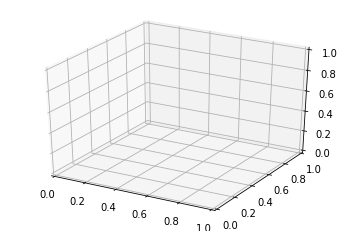

In [90]:
fig = plt.figure()
ax = plt.axes(projection="3d")

plt.show()

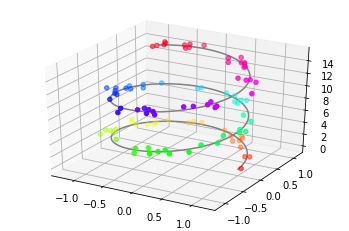

In [91]:

fig = plt.figure()
ax = plt.axes(projection="3d")

z_line = np.linspace(0, 15, 1000)
x_line = np.cos(z_line)
y_line = np.sin(z_line)
ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = 15 * np.random.random(100)
x_points = np.cos(z_points) + 0.1 * np.random.randn(100)
y_points = np.sin(z_points) + 0.1 * np.random.randn(100)
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');


plt.show()

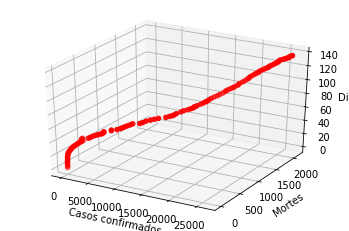

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =[covidRecife.confirmed]
y =[covidRecife.deaths]
z =[covidRecife.order_for_place]

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Casos confirmados')
ax.set_ylabel('Mortes')
ax.set_zlabel('Dias')

plt.show()

In [93]:
# aqui eu reuno as informações sobre mortes por dia de ambas as cidades
crec_dp100k = covidRecife.deaths_per_day_per_100k_inhabitants[0:136:1]
csp_dp100k = covidSP.deaths_per_day_per_100k_inhabitants[0:136:1]

In [94]:
# aqui eu concateno ambos os DataFrames e coloco o nome de cada box usando o keys do concat
df_rec_sp = pd.concat([crec_dp100k, csp_dp100k], axis=1, keys=['deaths_per_day_per_100k_in_Recife', 'deaths_per_day_per_100k_in_Sao_Paulo'])

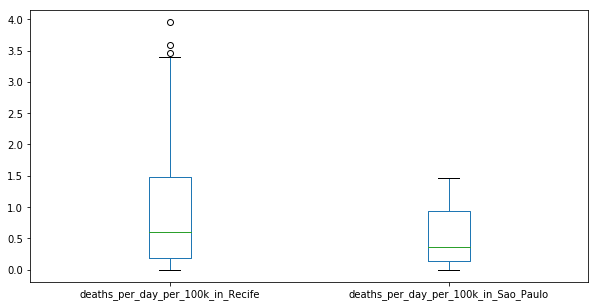

In [95]:
df_rec_sp.plot(kind='box', figsize=[10, 5])

In [96]:
# verificando se a diferença segue a gaussiana
# df_rec_sp['dpdp100k_difference'] = df_rec_sp.apply(lambda x: x['deaths_per_day_per_100k_in_Recife'] - x['deaths_per_day_per_100k_in_Sao_Paulo'], axis=1) or :
df_rec_sp['dpdp100k_difference'] = df_rec_sp['deaths_per_day_per_100k_in_Recife'] - df_rec_sp['deaths_per_day_per_100k_in_Sao_Paulo']
print(df_rec_sp)

     deaths_per_day_per_100k_in_Recife  deaths_per_day_per_100k_in_Sao_Paulo  \
0                             0.000000                              0.000000   
1                             0.000000                              0.000000   
2                             0.000000                              0.000000   
3                             0.000000                              0.000000   
4                             0.000000                              0.000000   
..                                 ...                                   ...   
131                           0.607634                              0.857001   
132                           0.303817                              0.938621   
133                           0.121527                              1.093697   
134                           0.546871                              0.905973   
135                           0.850688                              0.603982   

     dpdp100k_difference  
0           

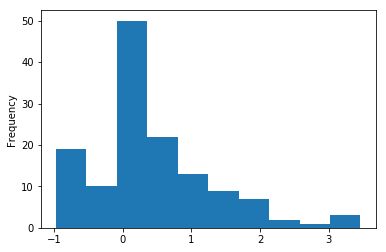

In [97]:
df_rec_sp['dpdp100k_difference'].plot(kind='hist')

In [98]:
# Shapiro-Wilk teste de normalidade que retorna o seguinte parametro: (valor, p-valor). Hipótese Nula: as mortes em Recife não são normalmente distribuídas.
stats.shapiro(df_rec_sp['dpdp100k_difference'])

# um p-valor menor que o valor crítico indica que a hipótese nula foi rejeitada / shapiro => retorn (valor crítico, p-valor)

(0.9222500324249268, 8.832834623717645e-07)

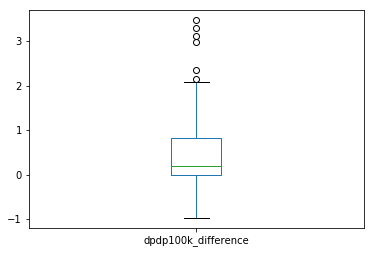

In [99]:
# checando simetria
df_rec_sp['dpdp100k_difference'].plot(kind='box')